<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/nearest_neighbour_analysis_2d_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cupy as cp
from scipy.special import erf
from sklearn.cluster import DBSCAN
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm

import time
import glob
import os
import gc

In [ ]:
k_power = 2
threshold = 11
eps = 100
min_samples = 2
loops = 100
pixel = 2**11
l = 1 ## box size = 2L+1

In [ ]:
def grf_2d(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = cp.random.normal(mean, std_dev, (pixel, pixel))

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = cp.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = cp.fft.fftfreq(pixel) * pixel
    ky = cp.fft.fftfreq(pixel) * pixel

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = cp.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = cp.sqrt(kx_grid**2 + ky_grid**2)
    k_norm[0, 0] = cp.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = amplitude * (((2 * cp.pi / pixel) * k_norm) ** (-k_power))
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = cp.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = cp.fft.ifft2(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field


def gaussian_to_exp(x, lam):
    mu = cp.mean(x)
    sigma = cp.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (cp.sqrt(2) * sigma)))
    return -1/lam  * cp.log(1 - xu)



def M(c2, c1, threshold):

    """
    First input : above-threshold overdensity
    Second input : above-threshold overdensity



    Define
    M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
    If[delta1 <= 0.599,
    HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

    delta2 (c2) is the amplitude of the above-threshold overdensity,
    delta1 (c1) is the amplitude of an overdensity in one of the
    nearest-neighbouring patches.

    For each nearest-neighbouring patch add deltaM to the mass
    of the "bare" above-threshold patch, M[0,delta2],
    to get the total mass in units of the horizon mass.

    """


    """
    linearly re-scale the amplitudes delta1 and delta2 such that
    0.6 corresponds to the utilised threshold value (at a given rareness).
    """

    c1 = 0.6 * c1 / threshold
    c2 = 0.6 * c2 / threshold


    if c1 <= 0.599:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181 * np.heaviside(c2 - 0.002/(c1-0.6) - 0.6, 0)

    else:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181


def dM(c2, c1, threshold):

    """
    Approximate mass increase for each nearest-neighbouring overdensity.
    (Through the "If" command, I have set it equal to zero whenever the
    threshold is not met.)

    deltaM[delta1,delta2]:=If[M[0, delta2] == 0, 0, M[delta1, delta2]-M[0, delta2]]
    """

    mass = M(c2,c1,threshold)

    if mass == 0:
        return 0
    else:
        return mass - M(c2,0,threshold)



# Total mass for a given threshold exceedence in a given cluster
# Sum over [k] and the threshold exceedenece
def nn_sum(dM_list):
    """
    M_total = Sum_{j in cluster} M[0, delta2_j]
    + Sum_{i=1}^{8} deltaM[delta1_i,delta2_j],
    wherein the second sum runs over all eight nearest neighbours.
    The indices j represents here the threshold exceeding events.
    """
    return np.sum(dM_ijk) + M(d2_ij, 0, threshold)
# print("neighborhood = ", np.sum(dM_ijk) , "bare =",  M(d2_ij, 0, threshold))

## Please then make a series of plots for each case (exponential and
## Gaußian random fields with n = 0, 1, 2, 3 each), wherein you
## compare the initial mass sepctrum (M0) with M_total

In [ ]:
k_power = 2
threshold = 11
eps = 100
min_samples = 2
l = 1 ## box size = 2L+1

In [ ]:
amplitude_list =[]
cluster_mass_list =[]
bare_mass_list =[]

t0 = time.time()

# Generate offsets for the 3x3 box
offsets = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1)])
# Generate offsets for the 3x3 box exlcuding center
offsets_no_center = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1) if not (i==0 and j==0)] )

# Mask for filtering
def filtering(x,y,pixel):
    domain_mask = (x >= 0) & (x < pixel) & (y >= 0) & (y < pixel)
    return x[domain_mask], y[domain_mask]


for nn in range(10000):

    if nn%100 == 0:
        print("Time for hundred loops:", np.round(time.time() - t0, 2 ) )
        t0 = time.time()

    exprf = gaussian_to_exp( grf_2d(mean= 0, std_dev = 1, pixel= pixel, amplitude = 1, k_power=k_power), 1)

    exprf = cp.asnumpy(exprf)

    pos = np.argwhere(exprf > threshold)

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(pos)

    labels = clustering.labels_

    num_clt = len(set(labels))
    # cmap = cm.get_cmap('rainbow', num_clt)

    # Initialize empty dictionary for threshold exceedence
    clt_pos_dict = {}
    # Initialize empty dictionary to store the all coordinates of the box
    coordinates = {}
    # Initialize empty dictionary to store the all unqiue coordinates of the box
    uni_coordinates = {}
    # Initialize empty dictionary to store only the nearest neighbour
    coordinates_nn = {}
    # Initialize empty dictionary to store o

    # Initialize empty dictionary - rank 2 tensor
    # Total mass for all threshold exceedence [j] in each clsuter [i]
    cluster_mass_list_ij, bare_mass_list_ij = {} , {}


    # Iterate over all clustes
    for ii in set(labels):

        # Find the index of the cluster
        clt_idx = np.where(labels == ii)
        # Find the coordinates of the cluster using the index
        clt_pos = pos[clt_idx]
        # Append the coordinates into the dictionary
        clt_pos_dict[ii] = clt_pos

    """
    Structure of the dictoinary:
    coordinates[i][j] referes to the coordinate of the i-th cluster
    and the j-th threshold exceeding events.
    """

    # Iterate over each cluster in labels, exlcuding `-1`
    for ii in set(labels) - {-1}:

        # Initialize empty list for collecting coordinates in cluster `ii`
        coordinates[ii] = []
        uni_coordinates[ii] = []
        coordinates_nn[ii] = []

        # Iterate over the coordinates of each box center
        for coor_center in clt_pos_dict[ii]:
            # Append the coordinates for the entire box (arrays)
            coordinates[ii].append(coor_center + offsets)
            # Append the coordinates only for the nearest neighbours
            coordinates_nn[ii].append(coor_center + offsets_no_center)

        # Concatenate lists of arrays into a single array
        coordinates[ii] = np.concatenate(coordinates[ii])

        # Remove duplications
        uni_coordinates[ii] = np.unique(coordinates[ii], axis=0)

    """
    Define indices and variables:

    i = Cluster
    j = Threshold Exceedence
    k = Nearest Neighbours


    d2 = delta2 = Threshold exceedence amplitude
    d1 = delta1 = Nearest neighbour amplitude
    """

    # for ii in set(labels) -{-1, 1, 2,3,4}:
    for ii in set(labels) -{-1}:
        #Intiialize empty list for each cluster for storing m_ijk
        cluster_mass_list_ij[ii], bare_mass_list_ij[ii] = [] , []

        for jj in range(clt_pos_dict[ii].shape[0]):
            ## amplitude of the j-th threshold exceedence in the i-th cluster - rank 2 tensor
            d2_ij = exprf[ clt_pos_dict[ii][jj,0], clt_pos_dict[ii][jj,1] ]

            x_ijk = coordinates_nn[ii][jj][:,0]
            y_ijk = coordinates_nn[ii][jj][:,1]

            if (clt_pos_dict[ii][jj,0] == 0 or clt_pos_dict[ii][jj,1] == 0 or clt_pos_dict[ii][jj,0] == pixel -1 or clt_pos_dict[ii][jj,1] == pixel -1 ):
                x_ijk, y_ijk = filtering(x_ijk, y_ijk, pixel)
                d1_ijk = exprf[x_ijk, y_ijk]

            else:
                ## amplitudes in the nearest neighbourhood for the j-th threshold exceedence - rank 3 tensor
                d1_ijk = exprf[ coordinates_nn[ii][jj][:,0], coordinates_nn[ii][jj][:,1] ]

            # Initialize empty list - rank 3 tensor
            ## delta M, additional mass due to nearest neighbour
            dM_ijk = []

            """
            Define
            M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
            If[delta1 <= 0.599,
            HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

            delta2 (d2) is the amplitude of the above-threshold overdensity,
            delta1 (d1) is the amplitude of an overdensity in one of the
            nearest-neighbouring patches.
            """

            # Calculate additional mass for each nearest neighbour
            for d1 in d1_ijk:
                dM_ijk.append( dM(d1, d2_ij, threshold) )
                # print("Amplitude =", d1, "Neighbor =", dM(d1, d2_ij, threshold) )

            # Total mass for a given threshold exceedence in a given cluster
            cluster_mass_list_ij[ii].append(nn_sum(dM_ijk))
            # Bare mass for a given threshold exceedence in a given cluster
            bare_mass_list_ij[ii].append(M(d2_ij, 0, threshold))

        # Record the total mass of the current cluster
        cluster_mass_list.append( np.sum(cluster_mass_list_ij[ii]) )
        # Record the total bare mass without nearest neighbours
        bare_mass_list.append( np.sum(bare_mass_list_ij[ii]) )
        # Record the amplitudes
        amplitude_list.append(d2_ij)
        amplitude_list.append(d1_ijk)


0
1
2
3
4
5
6
7
8
9


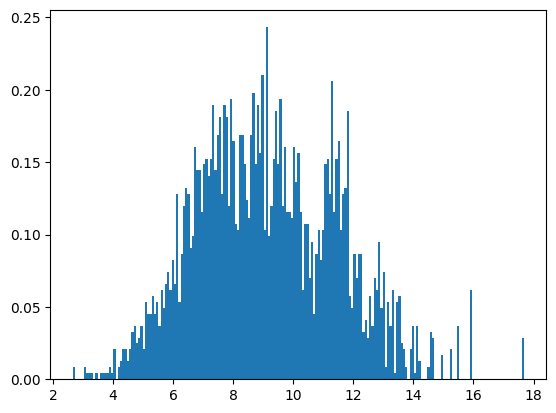

In [ ]:
plt.hist(np.concatenate(amplitude_list), bins=201, density=True);

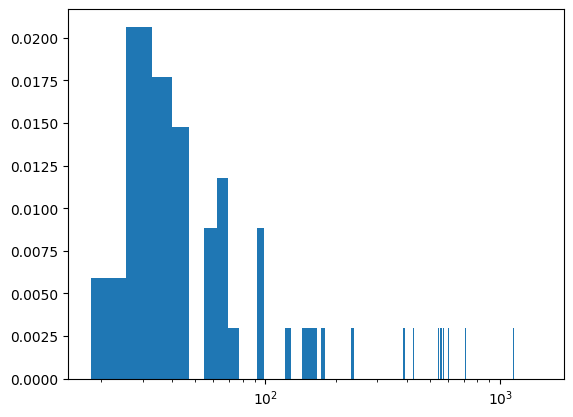

In [ ]:
plt.hist(cluster_mass_list, bins=201, density=True);
plt.xscale('log')

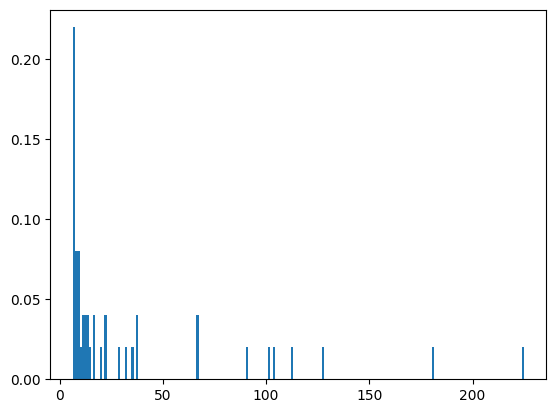

In [ ]:
plt.hist(bare_mass_list,bins=201,density=True);

In [ ]:


# Sort based on the first item in each sublist
sorted_data = sorted(data, key=lambda x: x[0])


[[1, 7], [2, 3], [4, 5]]